<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/MachineLeaning/blob/main/Boltzmann_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Reconstruction Error: 0.06201961662546289
Epoch 10, Reconstruction Error: 0.03622126874003679
Epoch 20, Reconstruction Error: 0.035081707804324014
Epoch 30, Reconstruction Error: 0.03519587240703732
Epoch 40, Reconstruction Error: 0.03479113395371288
Epoch 50, Reconstruction Error: 0.03477326633344168
Epoch 60, Reconstruction Error: 0.03498958906611904
Epoch 70, Reconstruction Error: 0.03512269257273539
Epoch 80, Reconstruction Error: 0.03500449061926578
Epoch 90, Reconstruction Error: 0.0349461231955138


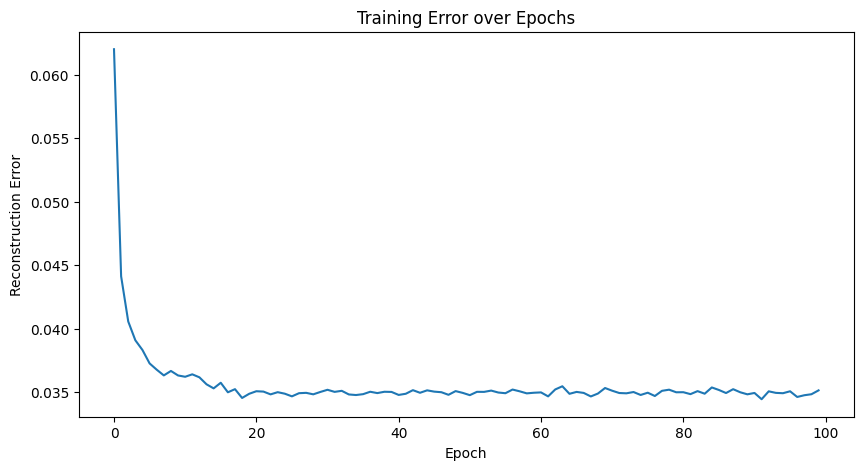

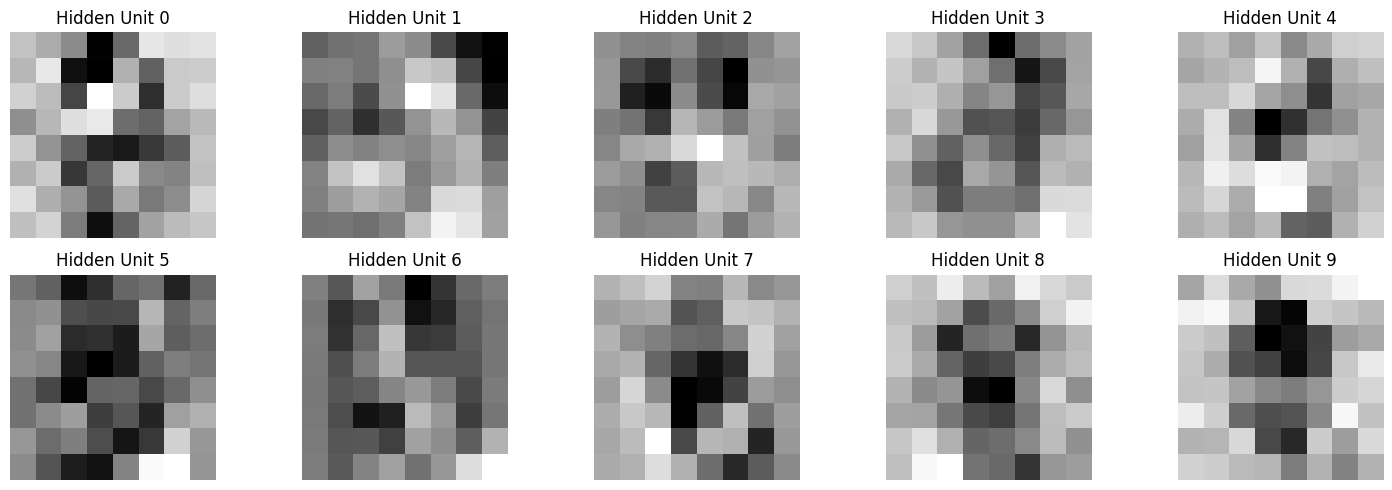

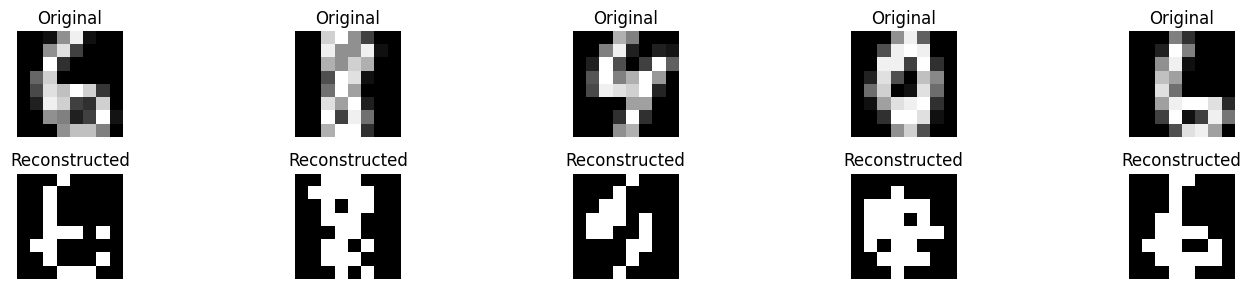

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler

class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.01):
        # 가중치 초기화
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # 가중치와 바이어스를 정규분포로 초기화
        self.weights = np.random.normal(0, 0.1, (n_visible, n_hidden))
        self.hidden_bias = np.zeros(n_hidden)
        self.visible_bias = np.zeros(n_visible)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_hidden(self, visible_probabilities):
        # 은닉층 활성화 확률 계산
        hidden_activations = np.dot(visible_probabilities, self.weights) + self.hidden_bias
        hidden_probabilities = self.sigmoid(hidden_activations)
        return hidden_probabilities, (hidden_probabilities > np.random.random(hidden_probabilities.shape))

    def sample_visible(self, hidden_probabilities):
        # 가시층 활성화 확률 계산
        visible_activations = np.dot(hidden_probabilities, self.weights.T) + self.visible_bias
        visible_probabilities = self.sigmoid(visible_activations)
        return visible_probabilities, (visible_probabilities > np.random.random(visible_probabilities.shape))

    def contrastive_divergence(self, visible_data, k=1):
        # Positive phase
        positive_hidden_probabilities, positive_hidden_states = self.sample_hidden(visible_data)

        # Negative phase
        hidden_states = positive_hidden_states
        for step in range(k):
            visible_probabilities, visible_states = self.sample_visible(hidden_states)
            hidden_probabilities, hidden_states = self.sample_hidden(visible_states)

        # 가중치 업데이트
        positive_associations = np.dot(visible_data.T, positive_hidden_probabilities)
        negative_associations = np.dot(visible_probabilities.T, hidden_probabilities)

        # 학습률을 적용하여 파라미터 업데이트
        self.weights += self.learning_rate * (positive_associations - negative_associations)
        self.hidden_bias += self.learning_rate * np.mean(positive_hidden_probabilities - hidden_probabilities, axis=0)
        self.visible_bias += self.learning_rate * np.mean(visible_data - visible_probabilities, axis=0)

        # 재구성 에러 계산
        error = np.mean((visible_data - visible_probabilities) ** 2)
        return error

    def train(self, data, n_epochs=100, batch_size=10):
        n_samples = data.shape[0]
        n_batches = n_samples // batch_size
        errors = []

        for epoch in range(n_epochs):
            epoch_error = 0
            # 미니배치 학습
            for batch in range(n_batches):
                start = batch * batch_size
                end = start + batch_size
                batch_data = data[start:end]
                epoch_error += self.contrastive_divergence(batch_data)

            epoch_error /= n_batches
            errors.append(epoch_error)

            if epoch % 10 == 0:
                print(f'Epoch {epoch}, Reconstruction Error: {epoch_error}')

        return errors

# 데이터 준비 (MNIST 숫자 데이터 사용)
digits = load_digits()
scaler = MinMaxScaler()
X = scaler.fit_transform(digits.data)

# RBM 모델 생성 및 학습
rbm = RBM(n_visible=64, n_hidden=100, learning_rate=0.01)
training_errors = rbm.train(X, n_epochs=100, batch_size=10)

# 학습 과정 시각화
plt.figure(figsize=(10, 5))
plt.plot(training_errors)
plt.title('Training Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Error')
plt.show()

# 학습된 가중치 시각화
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(rbm.weights[:, i].reshape(8, 8), cmap='gray')
    plt.title(f'Hidden Unit {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# 재구성 예제
def show_reconstruction(rbm, data, n_samples=5):
    # 원본 데이터에서 무작위로 샘플 선택
    idx = np.random.choice(data.shape[0], n_samples, replace=False)
    samples = data[idx]

    # 재구성
    hidden_prob, hidden_states = rbm.sample_hidden(samples)
    visible_prob, visible_states = rbm.sample_visible(hidden_states)

    # 시각화
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        # 원본 이미지
        plt.subplot(2, n_samples, i+1)
        plt.imshow(samples[i].reshape(8, 8), cmap='gray')
        plt.title('Original')
        plt.axis('off')

        # 재구성된 이미지
        plt.subplot(2, n_samples, n_samples+i+1)
        plt.imshow(visible_states[i].reshape(8, 8), cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 재구성 결과 시각화
show_reconstruction(rbm, X)